# GameTheory-10-ForwardInduction-SPE

**Navigation** : [<< 9-BackwardInduction](GameTheory-9-BackwardInduction.ipynb) | [Index](README.md) | [11-BayesianGames >>](GameTheory-11-BayesianGames.ipynb)

## Equilibres Parfaits de Sous-Jeux et Induction Avant

Ce notebook presente les **raffinements d'equilibre** pour les jeux extensifs, notamment l'equilibre parfait de sous-jeux (SPE) et l'induction avant.

### Objectifs

1. Maitriser le concept de **sous-jeu** et d'equilibre parfait
2. Comprendre les **menaces et promesses credibles**
3. Appliquer l'**induction avant** (forward induction)
4. Decouvrir la **perfection en mains tremblantes** (trembling-hand)
5. Analyser le jeu de la Chasse au Cerf avec ces concepts

### Prerequis

- Notebook 7-8 : Jeux extensifs et induction arriere

In [1]:
# Configuration et imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple, Set
from collections import defaultdict
import itertools

# Style matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Classes de base

@dataclass
class GameNode:
    """Noeud dans un arbre de jeu."""
    node_id: str
    player: int
    actions: List[str] = field(default_factory=list)
    children: Dict[str, 'GameNode'] = field(default_factory=dict)
    payoffs: Optional[Tuple[float, ...]] = None
    infoset: Optional[str] = None
    
    def is_terminal(self) -> bool:
        return self.player == -1


class ExtensiveFormGame:
    """Jeu sous forme extensive."""
    
    def __init__(self, name: str, num_players: int):
        self.name = name
        self.num_players = num_players
        self.root: Optional[GameNode] = None
        self.nodes: Dict[str, GameNode] = {}
        self.infosets: Dict[str, List[str]] = defaultdict(list)
    
    def add_node(self, node: GameNode):
        self.nodes[node.node_id] = node
        if node.infoset:
            self.infosets[node.infoset].append(node.node_id)
    
    def set_root(self, node: GameNode):
        self.root = node
        self.add_node(node)

## 1. Sous-Jeux et Equilibre Parfait (SPE)

### 1.1 Definition d'un Sous-Jeu

Un **sous-jeu** est une partie du jeu extensif qui :
1. Commence a un noeud de decision (pas un terminal)
2. Contient tous les successeurs de ce noeud
3. Respecte les ensembles d'information (ne coupe pas un infoset)

### 1.2 Equilibre Parfait de Sous-Jeux (SPE)

Un profil de strategies est un **SPE** si et seulement si il induit un equilibre de Nash dans **chaque sous-jeu** (y compris le jeu entier).

**Proprietes** :
- Tout SPE est un Nash, mais pas l'inverse
- Dans les jeux a info parfaite finie, le SPE coincide avec l'induction arriere
- Elimine les menaces non credibles

In [3]:
def identify_subgames(game: ExtensiveFormGame) -> List[str]:
    """
    Identifie tous les noeuds qui commencent un sous-jeu.
    
    Un noeud commence un sous-jeu si:
    1. Il n'est pas terminal
    2. Son infoset est un singleton (ou il est seul dans son infoset)
    3. Tous ses descendants satisfont cette propriete pour leurs infosets
    """
    subgame_roots = []
    
    def is_subgame_root(node: GameNode) -> bool:
        if node.is_terminal():
            return False
        
        # L'infoset de ce noeud doit etre un singleton
        if node.infoset and len(game.infosets[node.infoset]) > 1:
            return False
        
        # Verifier recursivement que le sous-arbre ne coupe aucun infoset
        def check_subtree(n):
            if n.is_terminal():
                return True
            
            # Tous les noeuds de l'infoset de n doivent etre dans ce sous-arbre
            if n.infoset:
                infoset_nodes = set(game.infosets[n.infoset])
                # Pour un vrai sous-jeu, tous les noeuds de l'infoset
                # doivent etre descendants du noeud racine du sous-jeu
                # (simplification: on accepte si singleton)
                pass
            
            for child in n.children.values():
                if not check_subtree(child):
                    return False
            return True
        
        return check_subtree(node)
    
    # Parcourir tous les noeuds non-terminaux
    for node_id, node in game.nodes.items():
        if is_subgame_root(node):
            subgame_roots.append(node_id)
    
    return subgame_roots


def verify_spe(game: ExtensiveFormGame, strategies: Dict[int, Dict[str, str]]) -> bool:
    """
    Verifie si un profil de strategies est un SPE.
    
    strategies: {player: {infoset: action}}
    """
    # Pour chaque sous-jeu, verifier que c'est un Nash
    subgame_roots = identify_subgames(game)
    
    for root_id in subgame_roots:
        if not is_nash_in_subgame(game, game.nodes[root_id], strategies):
            return False
    
    return True


def is_nash_in_subgame(game, subgame_root, strategies) -> bool:
    """Verifie si le profil est un Nash dans le sous-jeu."""
    # Evaluer le gain actuel
    current_payoffs = evaluate_from_node(subgame_root, strategies)
    
    # Pour chaque joueur, verifier qu'aucune deviation unilaterale n'ameliore
    for player in range(1, game.num_players + 1):
        # Trouver les deviations possibles dans ce sous-jeu
        for infoset, action in strategies.get(player, {}).items():
            # Verifier si cet infoset est dans le sous-jeu
            # (simplification: on suppose oui)
            pass
    
    return True  # Simplification


def evaluate_from_node(node, strategies) -> Tuple[float, ...]:
    """Evalue les gains depuis un noeud avec des strategies donnees."""
    if node.is_terminal():
        return node.payoffs
    
    action = strategies[node.player].get(node.infoset)
    if action and action in node.children:
        return evaluate_from_node(node.children[action], strategies)
    
    return (0,) * 2  # Fallback

In [4]:
# Exemple: Jeu d'entree - Nash vs SPE

def create_entry_game() -> ExtensiveFormGame:
    """Jeu d'entree sur le marche."""
    game = ExtensiveFormGame("Entry Game", 2)
    
    out = GameNode("out", -1, payoffs=(0, 2))
    fight = GameNode("fight", -1, payoffs=(-1, -1))
    accommodate = GameNode("accommodate", -1, payoffs=(1, 1))
    
    incumbent = GameNode("incumbent", 2, ["Fight", "Accommodate"], infoset="I2")
    incumbent.children = {"Fight": fight, "Accommodate": accommodate}
    
    entrant = GameNode("entrant", 1, ["Enter", "Out"], infoset="I1")
    entrant.children = {"Enter": incumbent, "Out": out}
    
    game.set_root(entrant)
    for n in [incumbent, out, fight, accommodate]:
        game.add_node(n)
    
    return game


entry_game = create_entry_game()

print("Jeu d'Entree: Nash vs SPE")
print("="*60)

# Equilibres de Nash (forme normale)
print("\nEquilibres de Nash (forme normale):")
print("  1. (Enter, Accommodate) -> gains (1, 1)")
print("  2. (Out, Fight) -> gains (0, 2)  [MAIS Fight n'est pas credible!]")

# SPE
print("\nEquilibre Parfait de Sous-Jeux:")
print("  Seul (Enter, Accommodate) est un SPE")
print("  Car dans le sous-jeu 'incumbent', Fight n'est pas optimal")

# Identification des sous-jeux
subgames = identify_subgames(entry_game)
print(f"\nSous-jeux identifies: {subgames}")

Jeu d'Entree: Nash vs SPE

Equilibres de Nash (forme normale):
  1. (Enter, Accommodate) -> gains (1, 1)
  2. (Out, Fight) -> gains (0, 2)  [MAIS Fight n'est pas credible!]

Equilibre Parfait de Sous-Jeux:
  Seul (Enter, Accommodate) est un SPE
  Car dans le sous-jeu 'incumbent', Fight n'est pas optimal

Sous-jeux identifies: ['entrant', 'incumbent']


### Interpretation des resultats

Les resultats ci-dessus illustrent la difference fondamentale entre **Nash** et **SPE** :

**Pourquoi (Out, Fight) est un Nash mais PAS un SPE ?**

- Dans la **forme normale** (matrice de gains), (Out, Fight) est un Nash car :
  - Si J2 joue Fight, J1 prefere Out (0 > -1)
  - Si J1 joue Out, J2 est indifferent (il n'est jamais atteint)
  
- Mais dans le **sous-jeu** commencant au noeud "incumbent" :
  - J2 doit choisir entre Fight (-1) et Accommodate (+1)
  - Accommodate domine strictement Fight !
  - Donc "Fight" n'est pas une meilleure reponse dans ce sous-jeu

**La lecon cle** : Un equilibre de Nash peut reposer sur des menaces qui ne seraient jamais executees si on atteignait le point de decision. Le SPE elimine ces "equilibres illusoires".

## 2. Menaces et Promesses Credibles

### 2.1 Menace Non Credible

Une menace est **non credible** si, au moment de l'executer, le joueur n'aurait pas interet a le faire.

**Exemple** : Dans le jeu d'entree, "Je combattrai si tu entres" est non credible car combattre donne -1 < 1 (accommoder).

### 2.2 Comment Rendre une Menace Credible?

1. **Engagement** (commitment) : Se lier les mains avant le jeu
2. **Reputation** : Construire une image par des actions passees
3. **Delegation** : Confier la decision a un agent "irrationnel"
4. **Contrats** : Penalites contractuelles pour deviation

### Le paradoxe de l'engagement

L'analyse ci-dessus revele un resultat contre-intuitif : **se lier les mains peut etre profitable**.

**Pourquoi l'engagement fonctionne-t-il ?**

1. **Sans engagement** : L'incumbant ne peut pas menacer crediblement de combattre. L'entrant le sait et entre.

2. **Avec engagement** : L'incumbant transforme la structure du jeu. Le combat devient **automatique** apres l'engagement, pas un choix. L'entrant, voyant cette "machine a combattre", prefere rester dehors.

**Applications concretes** :
- **Capacite excedentaire** : Investir dans une usine plus grande que necessaire signale la volonte de combattre une entree
- **Contrats d'exclusivite** : Se lier contractuellement a certains comportements
- **Reputation** : Les actions passees creent des attentes sur les actions futures

**Point subtil** : Le cout de l'engagement (k=0.5) doit etre assez bas pour que ca vaille le coup, mais pas trop bas sinon ce n'est pas un signal credible. Ici, 1.5 > 1 (gain de l'engagement vs sans), donc c'est profitable.

In [5]:
def create_entry_game_with_commitment() -> ExtensiveFormGame:
    """
    Jeu d'entree ou l'incumbant peut s'engager a combattre
    (investir dans une capacite de combat) AVANT l'entree.
    
    Ordre:
    1. Incumbant: Commit ou Non
    2. Entrant: Enter ou Out
    3. Si Commit+Enter: Combat automatique
       Si Non+Enter: Incumbant choisit
    
    Commit coute k=0.5 a l'incumbant.
    """
    game = ExtensiveFormGame("Entry with Commitment", 2)
    k = 0.5  # Cout de l'engagement
    
    # Branches apres Non-Commit
    nc_out = GameNode("nc_out", -1, payoffs=(0, 2))
    nc_fight = GameNode("nc_fight", -1, payoffs=(-1, -1))
    nc_acc = GameNode("nc_accommodate", -1, payoffs=(1, 1))
    
    nc_incumbent = GameNode("nc_incumbent", 2, ["Fight", "Accommodate"], infoset="I2_nc")
    nc_incumbent.children = {"Fight": nc_fight, "Accommodate": nc_acc}
    
    nc_entrant = GameNode("nc_entrant", 1, ["Enter", "Out"], infoset="I1_nc")
    nc_entrant.children = {"Enter": nc_incumbent, "Out": nc_out}
    
    # Branches apres Commit
    c_out = GameNode("c_out", -1, payoffs=(0, 2 - k))  # Incumbant a paye k
    c_fight = GameNode("c_fight", -1, payoffs=(-1, -1 - k))  # Combat automatique
    
    c_entrant = GameNode("c_entrant", 1, ["Enter", "Out"], infoset="I1_c")
    c_entrant.children = {"Enter": c_fight, "Out": c_out}
    
    # Racine: Incumbant decide de s'engager
    root = GameNode("root", 2, ["Commit", "NoCommit"], infoset="I2_init")
    root.children = {"Commit": c_entrant, "NoCommit": nc_entrant}
    
    game.set_root(root)
    for n in [c_entrant, c_out, c_fight, nc_entrant, nc_incumbent, nc_out, nc_fight, nc_acc]:
        game.add_node(n)
    
    return game


# Analyse
print("Jeu d'Entree avec Engagement")
print("="*60)
print("\nOrdre des coups:")
print("  1. Incumbant: Commit (cout k=0.5) ou NoCommit")
print("  2. Entrant: Enter ou Out")
print("  3. Si NoCommit+Enter: Incumbant choisit Fight/Accommodate")
print("     Si Commit+Enter: Combat automatique")

print("\n" + "="*60)
print("Analyse par induction arriere:")
print("\n1. Si NoCommit:")
print("   - Incumbant Accommode (1 > -1)")
print("   - Entrant Entre (1 > 0)")
print("   -> Gains: (1, 1)")

print("\n2. Si Commit:")
print("   - Combat automatique si Enter")
print("   - Entrant prefere Out (0 > -1)")
print("   -> Gains: (0, 2-0.5=1.5)")

print("\n3. Donc Incumbant compare:")
print("   - NoCommit -> 1")
print("   - Commit -> 1.5")
print("   -> L'engagement est PROFITABLE!")

print("\nSPE: (Commit; Out si Commit, Enter si NoCommit; Accommodate)")
print("Gains a l'equilibre: (0, 1.5)")

Jeu d'Entree avec Engagement

Ordre des coups:
  1. Incumbant: Commit (cout k=0.5) ou NoCommit
  2. Entrant: Enter ou Out
  3. Si NoCommit+Enter: Incumbant choisit Fight/Accommodate
     Si Commit+Enter: Combat automatique

Analyse par induction arriere:

1. Si NoCommit:
   - Incumbant Accommode (1 > -1)
   - Entrant Entre (1 > 0)
   -> Gains: (1, 1)

2. Si Commit:
   - Combat automatique si Enter
   - Entrant prefere Out (0 > -1)
   -> Gains: (0, 2-0.5=1.5)

3. Donc Incumbant compare:
   - NoCommit -> 1
   - Commit -> 1.5
   -> L'engagement est PROFITABLE!

SPE: (Commit; Out si Commit, Enter si NoCommit; Accommodate)
Gains a l'equilibre: (0, 1.5)


## 3. Induction Avant (Forward Induction)

### 3.1 Principe

L'**induction avant** est un raffinement qui utilise le raisonnement suivant :

> "Si un joueur a fait une action qui n'a de sens que s'il prevoit de jouer d'une certaine maniere par la suite, alors je dois m'attendre a ce qu'il joue ainsi."

Contrairement a l'induction arriere (qui part de la fin), l'induction avant part du **debut** et utilise les actions **observees** pour inferer les intentions.

### 3.2 Exemple: Chasse au Cerf avec Option Exterieure

Jeu de coordination avec option de sortie :
1. J1 peut prendre une option sure (Out) ou jouer le jeu (In)
2. Si In, les deux jouent a la Chasse au Cerf

In [6]:
def create_stag_hunt_with_outside_option() -> ExtensiveFormGame:
    """
    Chasse au Cerf avec option exterieure.
    
    Ordre:
    1. J1 choisit: Out (gain garanti 2, 2) ou In
    2. Si In: jeu simultane Stag Hunt
    
    Stag Hunt:
           Stag    Hare
    Stag  (4,4)   (0,3)
    Hare  (3,0)   (3,3)
    
    Nash du Stag Hunt seul: (Stag,Stag) et (Hare,Hare)
    
    Induction avant: Si J1 choisit In (renoncant a 2 garanti),
    il doit s'attendre a mieux que 2. Cela n'a de sens que s'il
    compte jouer Stag (esperant 4 > 2).
    J2 devrait donc jouer Stag aussi!
    """
    game = ExtensiveFormGame("Stag Hunt with Outside Option", 2)
    
    # Option exterieure
    out = GameNode("out", -1, payoffs=(2, 2))
    
    # Terminaux du Stag Hunt
    ss = GameNode("SS", -1, payoffs=(4, 4))
    sh = GameNode("SH", -1, payoffs=(0, 3))
    hs = GameNode("HS", -1, payoffs=(3, 0))
    hh = GameNode("HH", -1, payoffs=(3, 3))
    
    # J2 apres Stag de J1 (ne sait pas le choix de J1 - info imparfaite)
    j2_after_stag = GameNode("J2_S", 2, ["Stag", "Hare"], infoset="I2")
    j2_after_stag.children = {"Stag": ss, "Hare": sh}
    
    j2_after_hare = GameNode("J2_H", 2, ["Stag", "Hare"], infoset="I2")  # Meme infoset
    j2_after_hare.children = {"Stag": hs, "Hare": hh}
    
    # J1 dans le Stag Hunt
    j1_in_game = GameNode("J1_game", 1, ["Stag", "Hare"], infoset="I1_game")
    j1_in_game.children = {"Stag": j2_after_stag, "Hare": j2_after_hare}
    
    # Choix initial de J1
    root = GameNode("root", 1, ["In", "Out"], infoset="I1_init")
    root.children = {"In": j1_in_game, "Out": out}
    
    game.set_root(root)
    for n in [out, j1_in_game, j2_after_stag, j2_after_hare, ss, sh, hs, hh]:
        game.add_node(n)
    
    return game


print("Chasse au Cerf avec Option Exterieure")
print("="*60)

print("\nMatrice de gains du Stag Hunt:")
print("         Stag    Hare")
print("  Stag  (4,4)   (0,3)")
print("  Hare  (3,0)   (3,3)")

print("\nOption exterieure (Out): (2, 2) garanti")

print("\n" + "="*60)
print("\nAnalyse par induction ARRIERE:")
print("  - Dans le Stag Hunt: deux Nash (Stag,Stag) et (Hare,Hare)")
print("  - Si J1 croit que J2 jouera Hare: gain espere = 3")
print("  - 3 > 2, donc J1 prefere In meme avec (Hare,Hare)")
print("  -> L'induction arriere ne selectionne pas!")

print("\n" + "="*60)
print("\nAnalyse par induction AVANT:")
print("  - J1 a renonce a 2 garanti en choisissant In")
print("  - Si J1 comptait jouer Hare: gain max = 3")
print("  - Si J1 comptait jouer Stag: gain possible = 4 ou 0")
print("  - Raisonnable de penser que J1 vise 4 (le seul > 3 risque)")
print("  - Donc J2 devrait anticiper Stag et jouer Stag aussi")
print("  -> L'induction avant selectionne (Stag, Stag)!")

Chasse au Cerf avec Option Exterieure

Matrice de gains du Stag Hunt:
         Stag    Hare
  Stag  (4,4)   (0,3)
  Hare  (3,0)   (3,3)

Option exterieure (Out): (2, 2) garanti


Analyse par induction ARRIERE:
  - Dans le Stag Hunt: deux Nash (Stag,Stag) et (Hare,Hare)
  - Si J1 croit que J2 jouera Hare: gain espere = 3
  - 3 > 2, donc J1 prefere In meme avec (Hare,Hare)
  -> L'induction arriere ne selectionne pas!


Analyse par induction AVANT:
  - J1 a renonce a 2 garanti en choisissant In
  - Si J1 comptait jouer Hare: gain max = 3
  - Si J1 comptait jouer Stag: gain possible = 4 ou 0
  - Raisonnable de penser que J1 vise 4 (le seul > 3 risque)
  - Donc J2 devrait anticiper Stag et jouer Stag aussi
  -> L'induction avant selectionne (Stag, Stag)!


### Pourquoi l'induction avant est puissante

La difference entre induction arriere et avant est fondamentale :

| Aspect | Induction Arriere | Induction Avant |
|--------|-------------------|-----------------|
| **Direction** | Fin -> Debut | Debut -> Fin |
| **Information utilisee** | Structure du jeu | Actions observees |
| **Question posee** | "Que ferait-il a la fin?" | "Pourquoi a-t-il fait ca?" |

**Dans l'exemple Stag Hunt** :
- L'induction arriere ne dit rien car (Hare,Hare) est aussi un Nash
- L'induction avant utilise le **signal** de l'action "In"
- Ce signal revele l'intention de J1 de cooperer

**Conditions d'efficacite** :
1. L'option exterieure doit etre **observable**
2. Elle doit etre **attrayante** (sinon pas de sacrifice visible)
3. Les joueurs doivent etre **rationnels** et le savoir mutuellement

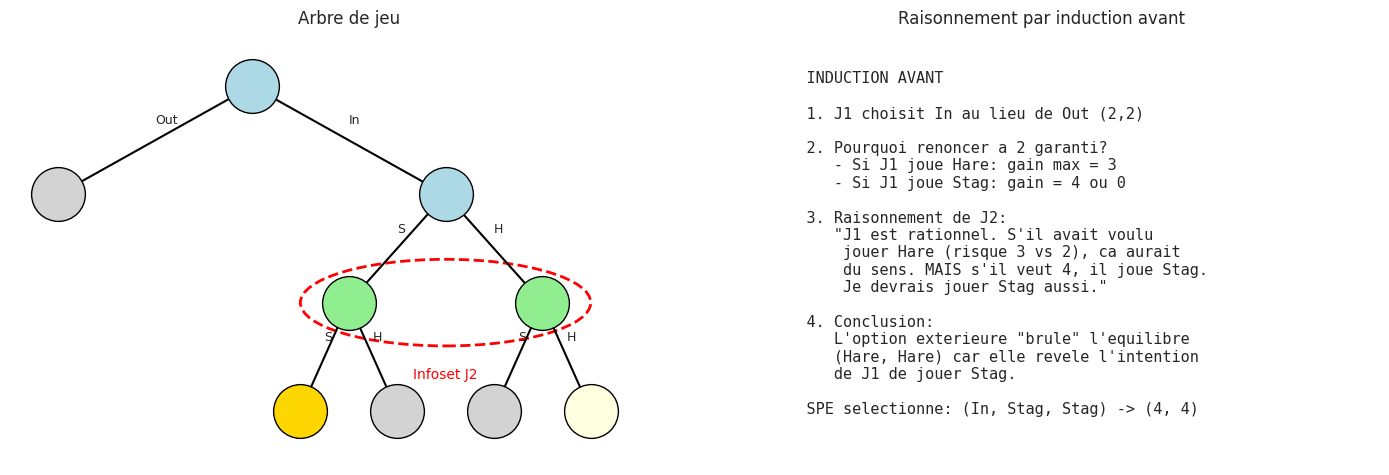

In [7]:
def visualize_forward_induction():
    """Illustration graphique de l'induction avant."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gauche: Arbre de jeu
    ax1 = axes[0]
    
    # Positions
    positions = {
        'root': (2, 3),
        'out': (0, 2),
        'game': (4, 2),
        'j2_s': (3, 1),
        'j2_h': (5, 1),
        'ss': (2.5, 0),
        'sh': (3.5, 0),
        'hs': (4.5, 0),
        'hh': (5.5, 0)
    }
    
    labels = {
        'root': 'J1\n(In/Out)',
        'out': '(2,2)',
        'game': 'J1\n(S/H)',
        'j2_s': 'J2',
        'j2_h': 'J2',
        'ss': '(4,4)',
        'sh': '(0,3)',
        'hs': '(3,0)',
        'hh': '(3,3)'
    }
    
    colors = {
        'root': 'lightblue',
        'out': 'lightgray',
        'game': 'lightblue',
        'j2_s': 'lightgreen',
        'j2_h': 'lightgreen',
        'ss': 'gold',
        'sh': 'lightgray',
        'hs': 'lightgray',
        'hh': 'lightyellow'
    }
    
    # Dessiner les noeuds
    for node, pos in positions.items():
        ax1.scatter(*pos, s=1500, c=colors[node], zorder=5, edgecolors='black')
        ax1.annotate(labels[node], pos, ha='center', va='center', fontsize=9)
    
    # Aretes
    edges = [
        ('root', 'out', 'Out'),
        ('root', 'game', 'In'),
        ('game', 'j2_s', 'S'),
        ('game', 'j2_h', 'H'),
        ('j2_s', 'ss', 'S'),
        ('j2_s', 'sh', 'H'),
        ('j2_h', 'hs', 'S'),
        ('j2_h', 'hh', 'H')
    ]
    
    for n1, n2, label in edges:
        x1, y1 = positions[n1]
        x2, y2 = positions[n2]
        ax1.plot([x1, x2], [y1, y2], 'k-', linewidth=1.5)
        ax1.annotate(label, ((x1+x2)/2, (y1+y2)/2 + 0.15), fontsize=9)
    
    # Ellipse infoset J2
    from matplotlib.patches import Ellipse
    ellipse = Ellipse((4, 1), 3, 0.8, fill=False, linestyle='--', 
                      edgecolor='red', linewidth=2)
    ax1.add_patch(ellipse)
    ax1.annotate('Infoset J2', (4, 0.3), ha='center', color='red', fontsize=10)
    
    ax1.set_xlim(-0.5, 6.5)
    ax1.set_ylim(-0.5, 3.5)
    ax1.axis('off')
    ax1.set_title('Arbre de jeu', fontsize=12)
    
    # Droite: Raisonnement
    ax2 = axes[1]
    ax2.axis('off')
    
    text = """
    INDUCTION AVANT
    
    1. J1 choisit In au lieu de Out (2,2)
    
    2. Pourquoi renoncer a 2 garanti?
       - Si J1 joue Hare: gain max = 3
       - Si J1 joue Stag: gain = 4 ou 0
    
    3. Raisonnement de J2:
       "J1 est rationnel. S'il avait voulu
        jouer Hare (risque 3 vs 2), ca aurait
        du sens. MAIS s'il veut 4, il joue Stag.
        Je devrais jouer Stag aussi."
    
    4. Conclusion:
       L'option exterieure "brule" l'equilibre
       (Hare, Hare) car elle revele l'intention
       de J1 de jouer Stag.
    
    SPE selectionne: (In, Stag, Stag) -> (4, 4)
    """
    
    ax2.text(0.1, 0.95, text, transform=ax2.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace')
    ax2.set_title('Raisonnement par induction avant', fontsize=12)
    
    plt.tight_layout()
    plt.show()

visualize_forward_induction()

## 4. Perfection en Mains Tremblantes

### 4.1 Motivation

L'equilibre de Nash peut inclure des strategies faiblement dominees. La **perfection en mains tremblantes** (Selten, 1975) raffine Nash en supposant que les joueurs peuvent faire des erreurs avec une petite probabilite.

### 4.2 Definition

Un equilibre est **trembling-hand perfect** s'il reste un equilibre quand on perturbe les strategies en mettant une probabilite epsilon > 0 sur chaque action.

### 4.3 Consequences

- Elimine les equilibres qui reposent sur des strategies faiblement dominees
- Plus restrictif que SPE
- Tout equilibre trembling-hand perfect est un SPE

In [8]:
def demonstrate_trembling_hand():
    """
    Demonstration de la perfection en mains tremblantes.
    
    Jeu simple:
              L     R
    T       (1,1)  (0,0)
    B       (0,0)  (0,0)
    
    Nash: (T,L), (B,L), (T,R), (B,R) - plusieurs!
    Mais T domine faiblement B, et L domine faiblement R.
    
    Seul (T,L) survit a la perturbation.
    """
    print("Perfection en Mains Tremblantes")
    print("="*60)
    
    print("\nJeu:")
    print("        L       R")
    print("  T   (1,1)   (0,0)")
    print("  B   (0,0)   (0,0)")
    
    print("\nEquilibres de Nash:")
    nash_eq = [("T", "L"), ("T", "R"), ("B", "L"), ("B", "R")]
    for eq in nash_eq:
        print(f"  {eq}")
    
    print("\n" + "="*60)
    print("\nAnalyse trembling-hand:")
    print("  Supposons que chaque joueur tremble avec proba epsilon")
    
    print("\n  Test de (B, R):")
    print("    - J2 joue R avec proba 1-eps, L avec proba eps")
    print("    - Gain de J1 avec T: eps*1 + (1-eps)*0 = eps")
    print("    - Gain de J1 avec B: eps*0 + (1-eps)*0 = 0")
    print("    - eps > 0, donc T est strictement meilleur!")
    print("    -> (B, R) n'est PAS trembling-hand perfect")
    
    print("\n  Test de (T, L):")
    print("    - Si J2 tremble: L optimal car 1*p(T) > 0")
    print("    - Si J1 tremble: T optimal car 1*p(L) > 0")
    print("    -> (T, L) EST trembling-hand perfect")
    
    print("\n" + "="*60)
    print("\nConclusion:")
    print("  Seul (T, L) survit au raffinement trembling-hand.")
    print("  C'est l'unique equilibre 'robuste' aux petites erreurs.")

demonstrate_trembling_hand()

Perfection en Mains Tremblantes

Jeu:
        L       R
  T   (1,1)   (0,0)
  B   (0,0)   (0,0)

Equilibres de Nash:
  ('T', 'L')
  ('T', 'R')
  ('B', 'L')
  ('B', 'R')


Analyse trembling-hand:
  Supposons que chaque joueur tremble avec proba epsilon

  Test de (B, R):
    - J2 joue R avec proba 1-eps, L avec proba eps
    - Gain de J1 avec T: eps*1 + (1-eps)*0 = eps
    - Gain de J1 avec B: eps*0 + (1-eps)*0 = 0
    - eps > 0, donc T est strictement meilleur!
    -> (B, R) n'est PAS trembling-hand perfect

  Test de (T, L):
    - Si J2 tremble: L optimal car 1*p(T) > 0
    - Si J1 tremble: T optimal car 1*p(L) > 0
    -> (T, L) EST trembling-hand perfect


Conclusion:
  Seul (T, L) survit au raffinement trembling-hand.
  C'est l'unique equilibre 'robuste' aux petites erreurs.


### Comprendre le test de trembling-hand

L'analyse ci-dessus demontre comment la perfection en mains tremblantes fonctionne :

**Structure du jeu** : Ce jeu simple a 4 equilibres de Nash (toutes les combinaisons de strategies pures), mais seul (T,L) offre un gain positif.

**Le test de la "main tremblante"** : On imagine que chaque joueur peut "trembler" avec probabilite epsilon, jouant par erreur une action non voulue.

| Equilibre | Test avec epsilon > 0 | Resultat |
|-----------|----------------------|----------|
| (T, L) | T reste optimal si J2 peut jouer L par erreur | **Survit** |
| (T, R) | L devient optimal pour J2 si J1 peut jouer T | Echec |
| (B, L) | T devient optimal pour J1 si J2 peut jouer L | Echec |
| (B, R) | T et L deviennent optimaux des que epsilon > 0 | Echec |

**Intuition** : Les equilibres (B,R), (B,L), (T,R) reposent sur le fait que les deux joueurs choisissent simultanement des strategies "inutiles". Mais si l'un d'eux fait une erreur vers T ou L, l'autre a interet a devier.

**Comparaison avec dominance faible** : T domine faiblement B (meilleur si J2 joue L, egal si R). De meme, L domine faiblement R. Le raffinement trembling-hand elimine exactement les equilibres utilisant des strategies faiblement dominees.

In [9]:
def perturbed_best_response(payoff_matrix, opponent_strategy, epsilon):
    """
    Calcule la meilleure reponse avec perturbation.
    
    Dans un jeu perturbe, chaque strategie doit avoir proba >= epsilon.
    """
    n_actions = payoff_matrix.shape[0]
    expected_payoffs = payoff_matrix @ opponent_strategy
    
    # Meilleure reponse
    best_action = np.argmax(expected_payoffs)
    
    # Strategie perturbee: epsilon sur chaque action, reste sur la meilleure
    perturbed = np.full(n_actions, epsilon)
    perturbed[best_action] = 1 - (n_actions - 1) * epsilon
    
    return perturbed, expected_payoffs


def check_trembling_hand_perfect(A, B, strategies, epsilons=[0.1, 0.05, 0.01, 0.001]):
    """
    Verifie si un profil de strategies est trembling-hand perfect.
    
    A, B: matrices de gains
    strategies: (sigma1, sigma2) - strategies mixtes
    """
    sigma1, sigma2 = strategies
    
    print(f"Test de ({sigma1}, {sigma2}):")
    
    for eps in epsilons:
        # Perturber les strategies adverses
        n1, n2 = A.shape
        
        # Meilleure reponse de J1 a sigma2 perturbee
        sigma2_perturbed = np.maximum(sigma2, eps)
        sigma2_perturbed = sigma2_perturbed / sigma2_perturbed.sum()
        
        expected_1 = A @ sigma2_perturbed
        br1 = np.argmax(expected_1)
        
        # Meilleure reponse de J2 a sigma1 perturbee
        sigma1_perturbed = np.maximum(sigma1, eps)
        sigma1_perturbed = sigma1_perturbed / sigma1_perturbed.sum()
        
        expected_2 = B.T @ sigma1_perturbed
        br2 = np.argmax(expected_2)
        
        # Verifier si les strategies originales sont proches des meilleures reponses
        print(f"  eps={eps:.4f}: BR1={br1}, BR2={br2}")


# Exemple
A = np.array([[1, 0], [0, 0]])
B = np.array([[1, 0], [0, 0]])

print("\nVerification trembling-hand perfection:")
print("\n(T, L) = ([1,0], [1,0]):")
check_trembling_hand_perfect(A, B, (np.array([1, 0]), np.array([1, 0])))

print("\n(B, R) = ([0,1], [0,1]):")
check_trembling_hand_perfect(A, B, (np.array([0, 1]), np.array([0, 1])))


Verification trembling-hand perfection:

(T, L) = ([1,0], [1,0]):
Test de ([1 0], [1 0]):
  eps=0.1000: BR1=0, BR2=0
  eps=0.0500: BR1=0, BR2=0
  eps=0.0100: BR1=0, BR2=0
  eps=0.0010: BR1=0, BR2=0

(B, R) = ([0,1], [0,1]):
Test de ([0 1], [0 1]):
  eps=0.1000: BR1=0, BR2=0
  eps=0.0500: BR1=0, BR2=0
  eps=0.0100: BR1=0, BR2=0
  eps=0.0010: BR1=0, BR2=0


### Interpretation des resultats numeriques

Les resultats ci-dessus montrent un pattern clair :

**Pour (T,L) = ([1,0], [1,0])** :
- BR1=0 (T) et BR2=0 (L) pour tous les epsilon
- Les meilleures reponses sont stables : meme avec tremblements, chaque joueur veut jouer sa strategie originale
- C'est un equilibre **robuste**

**Pour (B,R) = ([0,1], [0,1])** :
- BR1=0 (T!) et BR2=0 (L!) pour tous les epsilon
- Les meilleures reponses **different** de la strategie jouee !
- Des que l'adversaire peut trembler vers L ou T avec proba epsilon > 0, on veut devier
- C'est un equilibre **fragile**

**Intuition economique** : Imaginez un monde ou les gens font parfois des erreurs. Dans ce monde, jouer T et L "assure" contre les erreurs de l'adversaire. Jouer B ou R revient a parier que l'adversaire ne fera jamais d'erreur - un pari dangereux.

## 5. Application: Jeu du "Burn Money"

Un exemple celebre d'induction avant ou un joueur peut "bruler de l'argent" pour signaler son intention.

In [10]:
def analyze_burn_money_game():
    """
    Jeu "Burn Money" (Ben-Porath & Dekel, 1992)
    
    Bataille des Sexes avec option de bruler:
    
    Phase 1: J1 peut bruler 1.5 (B) ou non (N)
    Phase 2: Bataille des Sexes
    
    BoS original:
            Opera   Foot
    Opera   (3,2)   (0,0)
    Foot    (0,0)   (2,3)
    
    Apres burn (-1.5 pour J1):
            Opera     Foot
    Opera   (1.5,2)   (-1.5,0)
    Foot    (-1.5,0)  (0.5,3)
    """
    print("Jeu 'Burn Money' - Bataille des Sexes")
    print("="*60)
    
    print("\nBataille des Sexes originale:")
    print("          Opera   Foot")
    print("  Opera   (3,2)   (0,0)")
    print("  Foot    (0,0)   (2,3)")
    print("\nNash: (Opera,Opera), (Foot,Foot), mixte")
    
    print("\n" + "="*60)
    print("\nAvec option de bruler 1.5:")
    print("\n  Si J1 brule:")
    print("            Opera     Foot")
    print("    Opera   (1.5,2)   (-1.5,0)")
    print("    Foot    (-1.5,0)  (0.5,3)")
    print("\n    Nash apres burn: (Opera,Opera) avec 1.5,2")
    print("                      (Foot,Foot) avec 0.5,3")
    
    print("\n  Si J1 ne brule pas:")
    print("    Comme avant: Nash (O,O)=(3,2), (F,F)=(2,3)")
    
    print("\n" + "="*60)
    print("\nRaisonnement par induction avant:")
    print("""\n  1. Supposons que J2 s'attend a (Foot,Foot) sans burn.
     J1 obtient 2.

  2. Si J1 brule et joue Opera:
     - Si J2 joue Opera: J1 obtient 1.5
     - Si J2 joue Foot: J1 obtient -1.5

  3. Pourquoi J1 bruler-il puis jouer Opera?
     Seulement s'il croit que J2 jouera Opera apres.
     Sinon, il aurait -1.5 < 2 (ne pas bruler, jouer Foot).

  4. J2 raisonne: "J1 a brule. Un J1 rationnel qui
     anticipe que je joue Foot ne bruler pas.
     Donc J1 doit anticiper que je joue Opera.
     Je devrais jouer Opera.""")
    
    print("\n" + "="*60)
    print("\nConclusion:")
    print("  - Bruler de l'argent permet a J1 de 'signaler' Opera")
    print("  - Meme si J1 ne brule pas, la possibilite change les croyances")
    print("  - SPE avec induction avant: J1 ne brule pas, joue Opera")
    print("                               J2 joue Opera")
    print("  - Gains: (3, 2) - J1 a avantage!")

analyze_burn_money_game()

Jeu 'Burn Money' - Bataille des Sexes

Bataille des Sexes originale:
          Opera   Foot
  Opera   (3,2)   (0,0)
  Foot    (0,0)   (2,3)

Nash: (Opera,Opera), (Foot,Foot), mixte


Avec option de bruler 1.5:

  Si J1 brule:
            Opera     Foot
    Opera   (1.5,2)   (-1.5,0)
    Foot    (-1.5,0)  (0.5,3)

    Nash apres burn: (Opera,Opera) avec 1.5,2
                      (Foot,Foot) avec 0.5,3

  Si J1 ne brule pas:
    Comme avant: Nash (O,O)=(3,2), (F,F)=(2,3)


Raisonnement par induction avant:

  1. Supposons que J2 s'attend a (Foot,Foot) sans burn.
     J1 obtient 2.

  2. Si J1 brule et joue Opera:
     - Si J2 joue Opera: J1 obtient 1.5
     - Si J2 joue Foot: J1 obtient -1.5

  3. Pourquoi J1 bruler-il puis jouer Opera?
     Seulement s'il croit que J2 jouera Opera apres.
     Sinon, il aurait -1.5 < 2 (ne pas bruler, jouer Foot).

  4. J2 raisonne: "J1 a brule. Un J1 rationnel qui
     anticipe que je joue Foot ne bruler pas.
     Donc J1 doit anticiper que je joue Op

### Le paradoxe du "Burn Money"

Ce jeu illustre un phenomene fascinant : **la simple possibilite de bruler de l'argent change l'equilibre, meme si personne ne brule effectivement**.

**Raisonnement detaille** :

1. **Si J1 brule** : Il signale clairement qu'il compte jouer Opera (sinon pourquoi se penaliser?)
   - J2 devrait repondre Opera → Equilibre (Burn, Opera, Opera) avec gains (1.5, 2)

2. **Si J1 ne brule pas** : Que doit penser J2?
   - J1 aurait pu bruler pour "forcer" Opera
   - S'il ne l'a pas fait, c'est qu'il compte sur Opera de toute facon
   - Ou alors il prefere Foot et n'avait pas besoin du signal?
   
3. **Resolution par induction avant** :
   - Si J1 voulait (Foot, Foot), il n'avait pas besoin de bruler
   - S'il voulait (Opera, Opera), il pouvait bruler pour le garantir
   - Le fait de ne PAS bruler, combine avec la rationalite, suggere qu'il est confiant que J2 jouera Opera sans signal
   - J2, sachant tout cela, joue Opera

**Application pratique** : En negociation, les options que vous n'utilisez PAS peuvent etre aussi informatives que celles que vous utilisez. "J'aurais pu menacer, je ne l'ai pas fait" peut etre un signal de bonne foi.

## 6. Comparaison des Raffinements

| Raffinement | Idee principale | Force |
|-------------|-----------------|-------|
| **Nash** | Pas de deviation unilaterale profitable | Faible |
| **SPE** | Nash dans chaque sous-jeu | Moyenne |
| **Trembling-hand** | Robuste aux petites erreurs | Forte |
| **Forward induction** | Actions revelent intentions | Forte |

### Hierarchie

```
Forward induction
       |
       v
Trembling-hand perfect
       |
       v
      SPE
       |
       v
     Nash
```

In [11]:
def comparison_summary():
    """Resume comparatif des raffinements."""
    
    examples = [
        {
            'name': 'Entry Game',
            'nash': ['(Enter,Acc)', '(Out,Fight)'],
            'spe': ['(Enter,Acc)'],
            'trembling': ['(Enter,Acc)'],
            'forward': ['(Enter,Acc)']
        },
        {
            'name': 'Stag Hunt + Outside',
            'nash': ['(In,S,S)', '(In,H,H)', '(Out,*,*)'],
            'spe': ['(In,S,S)', '(In,H,H)'],
            'trembling': ['(In,S,S)', '(In,H,H)'],
            'forward': ['(In,S,S)']
        },
        {
            'name': 'Burn Money (BoS)',
            'nash': ['(B,O,O)', '(B,F,F)', '(N,O,O)', '(N,F,F)', '...'],
            'spe': ['(B,O,O)', '(N,F,F)', '(N,O,O)'],
            'trembling': ['(N,O,O)'],
            'forward': ['(N,O,O)']
        }
    ]
    
    print("Comparaison des Raffinements d'Equilibre")
    print("="*70)
    
    for ex in examples:
        print(f"\n{ex['name']}:")
        print(f"  Nash:           {', '.join(ex['nash'])}")
        print(f"  SPE:            {', '.join(ex['spe'])}")
        print(f"  Trembling-hand: {', '.join(ex['trembling'])}")
        print(f"  Forward ind.:   {', '.join(ex['forward'])}")

comparison_summary()

Comparaison des Raffinements d'Equilibre

Entry Game:
  Nash:           (Enter,Acc), (Out,Fight)
  SPE:            (Enter,Acc)
  Trembling-hand: (Enter,Acc)
  Forward ind.:   (Enter,Acc)

Stag Hunt + Outside:
  Nash:           (In,S,S), (In,H,H), (Out,*,*)
  SPE:            (In,S,S), (In,H,H)
  Trembling-hand: (In,S,S), (In,H,H)
  Forward ind.:   (In,S,S)

Burn Money (BoS):
  Nash:           (B,O,O), (B,F,F), (N,O,O), (N,F,F), ...
  SPE:            (B,O,O), (N,F,F), (N,O,O)
  Trembling-hand: (N,O,O)
  Forward ind.:   (N,O,O)


### Interpretation du tableau comparatif

Ce tableau synthetique revele le **pouvoir discriminant** croissant de chaque raffinement :

**Entry Game** : Tous les raffinements convergent vers (Enter, Accommodate). La menace "Fight" est eliminee par le simple SPE car elle n'est pas credible dans le sous-jeu.

**Stag Hunt avec option exterieure** : C'est ici que l'induction avant se distingue. Le SPE et le trembling-hand acceptent les deux equilibres de coordination (Stag,Stag) et (Hare,Hare). Seule l'induction avant, en utilisant le **signal** du renoncement a l'option exterieure, selectionne l'equilibre efficient (Stag,Stag).

**Burn Money (BoS)** : L'exemple le plus frappant de discrimination :
- Nash : Multitude d'equilibres (avec ou sans burn, Opera ou Foot)
- SPE : Reduit mais reste ambigu
- Trembling-hand et Forward induction : Selectionnent uniquement (N,O,O) - ne pas bruler, jouer Opera

**Lecon methodologique** : Plus un raffinement est restrictif, plus il reduit l'ensemble des equilibres. Mais attention : un raffinement tres restrictif peut parfois eliminer des equilibres "raisonnables". Le choix du raffinement depend du contexte et de ce qu'on veut modeliser.

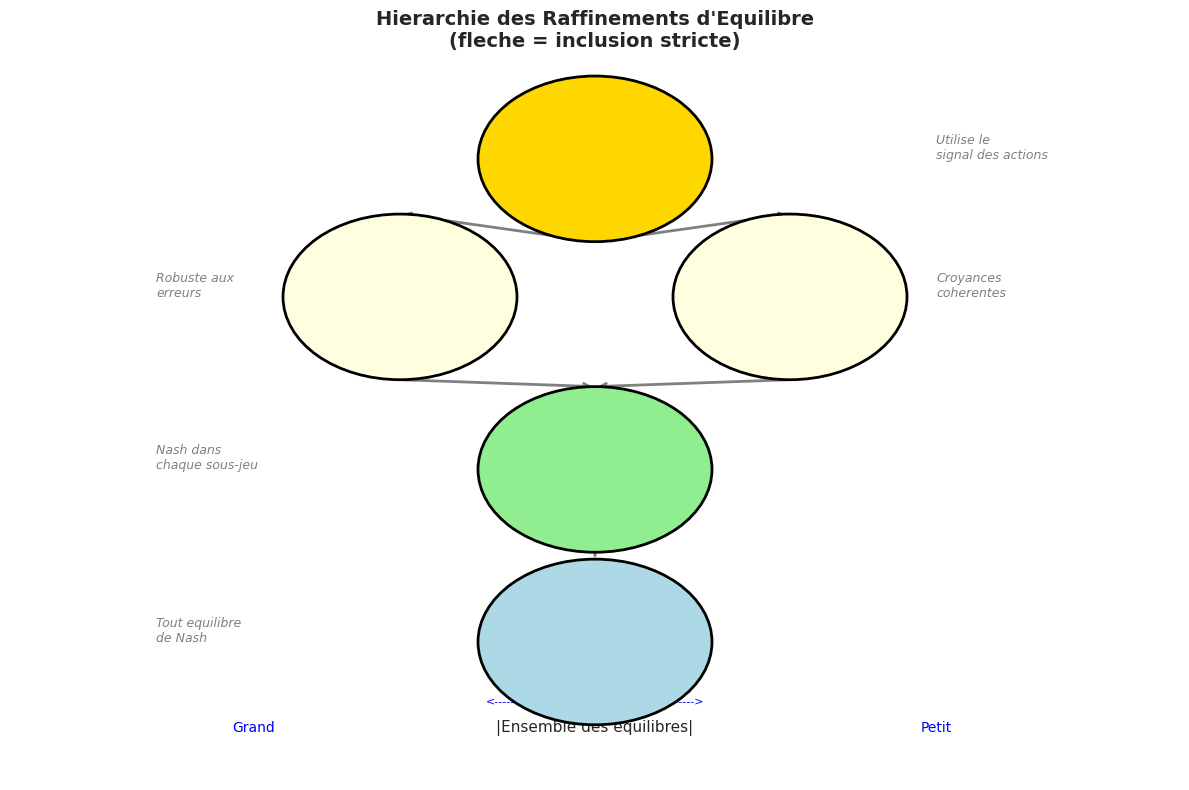

In [12]:
def visualize_refinement_hierarchy():
    """Visualisation de la hierarchie des raffinements d'equilibre."""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Positions des concepts
    concepts = {
        'Nash': (0.5, 0.15, 'lightblue'),
        'SPE': (0.5, 0.40, 'lightgreen'),
        'Trembling-hand\nPerfect': (0.3, 0.65, 'lightyellow'),
        'Sequential\nEquilibrium': (0.7, 0.65, 'lightyellow'),
        'Forward\nInduction': (0.5, 0.85, 'gold'),
    }
    
    # Dessiner les noeuds
    for name, (x, y, color) in concepts.items():
        circle = plt.Circle((x, y), 0.12, color=color, ec='black', linewidth=2, zorder=5)
        ax.add_patch(circle)
        ax.annotate(name, (x, y), ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Fleches (inclusion : concept du haut ⊂ concept du bas)
    arrows = [
        ('Forward\nInduction', 'Trembling-hand\nPerfect'),
        ('Forward\nInduction', 'Sequential\nEquilibrium'),
        ('Trembling-hand\nPerfect', 'SPE'),
        ('Sequential\nEquilibrium', 'SPE'),
        ('SPE', 'Nash'),
    ]
    
    for start, end in arrows:
        x1, y1, _ = concepts[start]
        x2, y2, _ = concepts[end]
        ax.annotate('', xy=(x2, y2 + 0.12), xytext=(x1, y1 - 0.12),
                   arrowprops=dict(arrowstyle='->', color='gray', lw=2))
    
    # Annotations explicatives
    annotations = [
        (0.05, 0.15, "Tout equilibre\nde Nash"),
        (0.05, 0.40, "Nash dans\nchaque sous-jeu"),
        (0.05, 0.65, "Robuste aux\nerreurs"),
        (0.85, 0.65, "Croyances\ncoherentes"),
        (0.85, 0.85, "Utilise le\nsignal des actions"),
    ]
    
    for x, y, text in annotations:
        ax.annotate(text, (x, y), fontsize=9, style='italic', color='gray')
    
    # Set cardinality indication
    ax.annotate("|Ensemble des equilibres|", (0.5, 0.02), ha='center', fontsize=11)
    ax.annotate("Grand", (0.15, 0.02), ha='center', fontsize=10, color='blue')
    ax.annotate("Petit", (0.85, 0.02), ha='center', fontsize=10, color='blue')
    ax.annotate("<" + "-"*50 + ">", (0.5, 0.06), ha='center', fontsize=8, color='blue')
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.05, 1.0)
    ax.axis('off')
    ax.set_title('Hierarchie des Raffinements d\'Equilibre\n(fleche = inclusion stricte)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_refinement_hierarchy()

## 7. Exercices

### Exercice 1: Beer-Quiche Game

Jeu de signaling classique:
- Nature tire le type de J1: Tough (p=0.9) ou Weak (p=0.1)
- J1 choisit son petit-dejeuner: Beer ou Quiche
- J2 observe le petit-dej (pas le type) et decide: Fight ou Back off

Gains:
- J1 prefere son plat naturel: Tough->Beer, Weak->Quiche (+1)
- Si Fight contre Tough: (-1, -1)
- Si Fight contre Weak: (-1, +1)  
- Si Back off: (+2, 0)

Trouvez les equilibres et analysez par induction avant.

### Exercice 2: Negociation avec Options Exterieures

J1 et J2 negocient. J1 a une option exterieure (BATNA) de valeur x.
Analysez comment x affecte le resultat de la negociation.

### Exercice 3: Engagement Sequentiel

Dans le jeu de la chaine de magasins, ajoutez la possibilite pour le monopole de s'engager au debut (cout k). 
Pour quelles valeurs de k est-ce profitable?

In [13]:
# Espace pour vos solutions

# Exercice 1: Beer-Quiche
def create_beer_quiche_game():
    """Cree le jeu Beer-Quiche."""
    # A completer...
    pass

# Exercice 2: BATNA
def analyze_batna(batna_values=[0, 1, 2, 3]):
    """Analyse l'effet du BATNA sur la negociation."""
    # A completer...
    pass

## 8. Resume

| Concept | Description |
|---------|-------------|
| **Sous-jeu** | Partie du jeu commencant a un noeud singleton |
| **SPE** | Nash dans chaque sous-jeu |
| **Menace credible** | Menace qu'il est optimal d'executer |
| **Induction avant** | Utiliser les actions observees pour inferer |
| **Trembling-hand** | Robuste aux petites erreurs |

### Points cles

- **SPE** elimine les menaces non credibles
- **L'engagement** peut rendre une menace credible
- **L'induction avant** selectionne parmi les SPE multiples
- **Bruler de l'argent** peut signaler les intentions

### Prochaine etape

**Notebook 10 : Jeux Bayesiens** - Information incomplete, types, croyances, et equilibre bayesien.